In [41]:
import pickle
import torch
from src.impute import impute_cvae_naive
from src.vae.mnist_vae import ConditionalVae
import numpy as np

for dirichlet in np.linspace(0.1,1, 10):
    dirichlet = round(dirichlet, 1)
    cvae = ConditionalVae(dim_encoding=3)
    checkpoint = torch.load(f'C:\\Users\\lyada\\Desktop\\FederatedImputation\\vae_data\\models\\0_cvae_{dirichlet}.pth')
    cvae.load_state_dict(checkpoint)
    gen_dataset = impute_cvae_naive(k=70000, trained_cvae = cvae, initial_dataset = torch.tensor([]))
    print(gen_dataset[0][0].shape)
    # Use pickle to save the list to a file
    with open(f'gen_dataset_{dirichlet}.pkl', 'wb') as f:
        pickle.dump(gen_dataset, f)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


7
0
6
6
3
6
0
2
7
2
9
0
4
8
2
3
6
7
4
8


60000

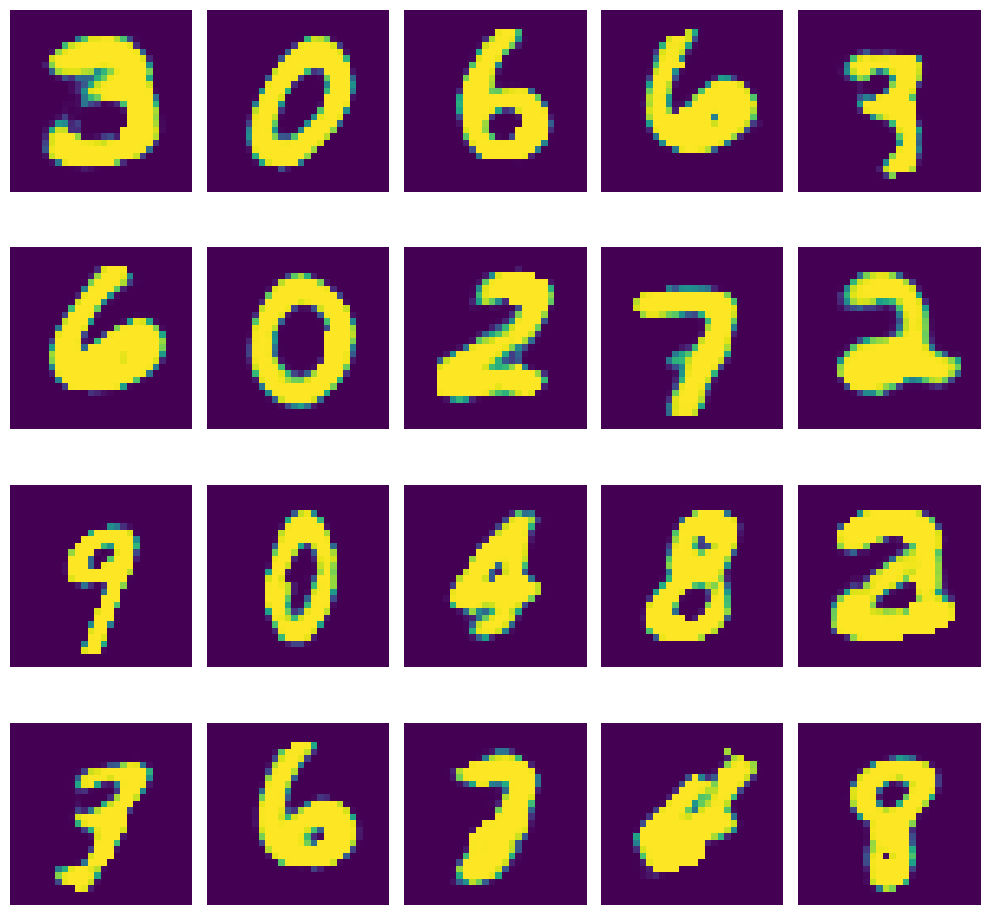

In [40]:
from src.plots import plot_image
loaded_gen = pickle.load(open('gen_dataset_1.0.pkl', 'rb'))
plot_image([g for g, _ in loaded_gen], num_imgs=20)
[print(loaded_gen[i][1]) for i in range(20)]
len(loaded_gen)

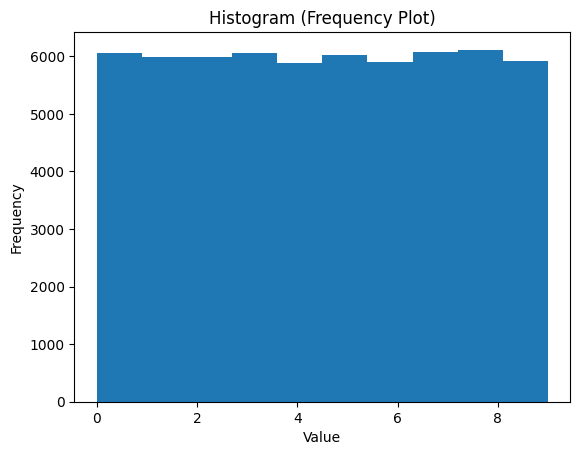

In [36]:

import random
import matplotlib.pyplot as plt
import numpy as np

# generate some random data
labels = [label for _, label in loaded_gen]
# Create the histogram
plt.hist(labels, bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram (Frequency Plot)')

# Show the plot
plt.show()


In [45]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset

lengths = [60000, 10000]
data = pickle.load(open('gen_dataset_1.0.pkl', 'rb'))

generated_train_dataset, generated_test_dataset = random_split(data, lengths)

trainloader = DataLoader(generated_train_dataset,
                                 batch_size=32, shuffle=True)
testloader = DataLoader(generated_test_dataset,
                                 batch_size=32, shuffle=True)

In [81]:
from sklearn.metrics import f1_score
from torch.utils.data import DataLoader
from torch.version import cuda
from src.models import ExquisiteNetV1
import torch
from torch import nn, optim
device = 'cuda:0'
print(device)
# Assuming 'model' is your model
model = ExquisiteNetV1(class_num=10, img_channels=1)
model = model.to(device)  # Move model to GPU if available

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs to train the model
n_epochs = 20
train_losses = []
test_losses = []
f1_scores = []
for epoch in range(n_epochs):
    train_loss = 0.0
    pred_labels = []
    actual_labels = []
    for data, target in trainloader:  # Assuming 'trainloader' is your DataLoader
        data, target = data.to(device), target.to(device) # Move data to GPU if available

        # Clear the gradients of all optimized variables
        optimizer.zero_grad()

        # Forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        pred_labels.append(output.argmax(dim=1))
        actual_labels.append(target)

        # Calculate the loss
        loss = criterion(output, target)

        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()

        # Perform single optimization step (parameter update)
        optimizer.step()

        # Update running training loss
        train_loss += loss.item() * data.size(0)

    # Switch to evaluation mode
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        test_pred_labels = []
        test_actual_labels = []
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item() * data.size(0)
            test_pred_labels.append(output.argmax(dim=1))
            test_actual_labels.append(target)

    # Compute average test loss
    train_loss = train_loss/len(trainloader.dataset)
    test_loss = test_loss/len(testloader.dataset)
    test_losses.append(test_loss)
    train_losses.append(train_loss)
    # Calculate F1 score for the test data
    test_pred_labels = torch.cat(test_pred_labels).to('cpu').numpy()
    test_actual_labels = torch.cat(test_actual_labels).to('cpu').numpy()
    test_f1_score = f1_score(test_actual_labels, test_pred_labels, average='macro')
    f1_scores.append(test_f1_score)
    print('Epoch: {} \tTraining Loss: {:.6f} \t Test Loss: {:.6f} \tF1 Test Macro: {:.6f}'.format(
        epoch + 1,
        train_loss,
        test_loss,
        test_f1_score
    ))

cuda:0
Epoch: 1 	Training Loss: 0.159485 	 Test Loss: 0.047806 	F1 Test Macro: 0.983306
Epoch: 2 	Training Loss: 0.097326 	 Test Loss: 0.117092 	F1 Test Macro: 0.962583
Epoch: 3 	Training Loss: 0.053609 	 Test Loss: 0.066490 	F1 Test Macro: 0.980021
Epoch: 4 	Training Loss: 0.045794 	 Test Loss: 0.018363 	F1 Test Macro: 0.994249
Epoch: 5 	Training Loss: 0.035282 	 Test Loss: 0.015659 	F1 Test Macro: 0.995048
Epoch: 6 	Training Loss: 0.038687 	 Test Loss: 0.016730 	F1 Test Macro: 0.994053
Epoch: 7 	Training Loss: 0.031951 	 Test Loss: 0.037038 	F1 Test Macro: 0.989292
Epoch: 8 	Training Loss: 0.028847 	 Test Loss: 0.026975 	F1 Test Macro: 0.991184
Epoch: 9 	Training Loss: 0.022659 	 Test Loss: 0.014535 	F1 Test Macro: 0.995833
Epoch: 10 	Training Loss: 0.028744 	 Test Loss: 0.015170 	F1 Test Macro: 0.994841
Epoch: 11 	Training Loss: 0.020579 	 Test Loss: 0.013376 	F1 Test Macro: 0.995856
Epoch: 12 	Training Loss: 0.022532 	 Test Loss: 0.028890 	F1 Test Macro: 0.992514
Epoch: 13 	Trainin

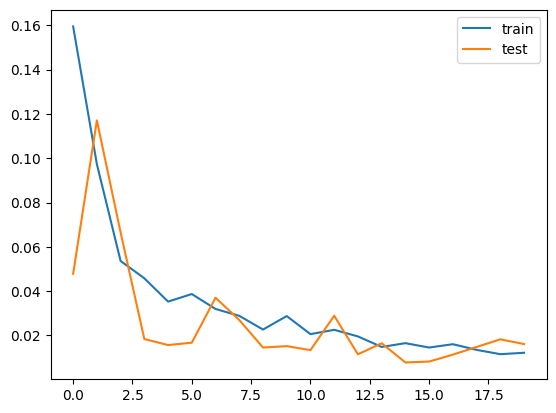

[0.9833058758968376, 0.9625834919522767, 0.980021397621887, 0.9942494361618397, 0.9950484538134109, 0.9940529459040081, 0.9892921517488815, 0.9911839876278051, 0.9958334436627366, 0.9948412384571121, 0.9958564912847578, 0.9925143292260691, 0.9973199875652302, 0.9953501286448325, 0.9980159457320419, 0.9971101383983549, 0.9962295806636547, 0.9954297964755275, 0.9946200810547919, 0.9948455939685583]


In [82]:
plt.plot(train_losses, label = f"train")
plt.plot(test_losses, label = f"test")
plt.legend()
plt.show()
print(f1_scores)

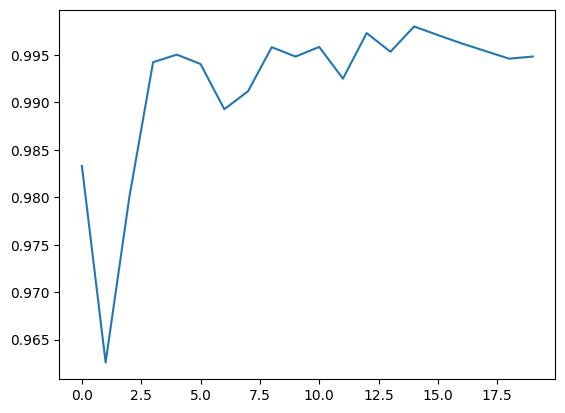

In [83]:
plt.plot(f1_scores, label = f"f1")
